[cv的两种用途](https://zhuanlan.zhihu.com/p/113623623)  

看懂周志华那个，搞清楚到底需要怎么评估

看懂模型到底如何训练的，耐下心来

https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-pytorch.md
https://github.com/taipingeric/ML-for-Newbies/blob/main/Cross%20validation/KFold-CrossValidation-PyTorch.ipynb
https://androidkt.com/pytorch-k-fold-cross-validation-using-dataloader-and-sklearn/

In [1]:
from __future__ import print_function
import argparse
import numpy  as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms

from data_loaders import Plain_Dataset, eval_data_dataloader
from deep_emotion import Deep_Emotion
from generate_data import Generate_data


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
import cv2
import os
import math
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from tqdm.auto import tqdm
data_path = 'jaffe_raw/'
save_path = 'jaffe_new/'

1. 弄一个excel表 放上 jaffe 的 train和vali
2. split 适用 sklearn
3. 写一个 def train 和def test
4. 最后取平均  看看模型的acc有啥差别

## create csv
use 120 images for training
23 images for validation
70 images for test (10 images per emotion in the test set). 

In [3]:
np.random.seed(100)
with open('jaffe.csv','r') as csvfile:
    reader = csv.reader(csvfile)
    rows = [row for row in reader]


In [4]:
print(len(rows))
random_array = np.arange(len(rows))

213


In [5]:
cnt_an = 0
cnt_di = 0
cnt_fe = 0
cnt_ha = 0
cnt_sa = 0
cnt_su = 0
cnt_ne = 0
loop = True

cnt = 0

st = []
st_lbl = []
idx = []
while loop:
    temp = np.random.choice(random_array)
    item = rows[temp][0]
    lbl = int(rows[temp][1])
    if item not in st:
        
        if lbl == 0 and cnt_an<10 :
            cnt_an = cnt_an+1
            st_lbl.append(lbl)
            st.append(item)
            idx.append(temp)
        elif lbl==1 and cnt_di<10:
            cnt_di = cnt_di+1
            st_lbl.append(lbl)
            st.append(item)
            idx.append(temp)
        elif lbl==2 and cnt_fe<10:
            cnt_fe = cnt_fe+1
            st_lbl.append(lbl)
            st.append(item)
            idx.append(temp)
        elif lbl==3 and cnt_ha<10:
            cnt_ha = cnt_ha +1
            st_lbl.append(lbl)
            st.append(item)
            idx.append(temp)
        elif lbl == 4 and cnt_sa<10:
            cnt_sa = cnt_sa +1
            st_lbl.append(lbl)
            st.append(item)
            idx.append(temp)
        elif lbl==5 and cnt_su<10:
            cnt_su = cnt_su+1
            st_lbl.append(lbl)
            st.append(item)
            idx.append(temp)
        elif lbl==6 and cnt_ne<10:
            cnt_ne = cnt_ne+1
            st_lbl.append(lbl)
            st.append(item)
            idx.append(temp)

#         print(len(st))
        if cnt_an==10 and cnt_di==10 and cnt_fe==10 and cnt_ha==10 and cnt_sa==10 and cnt_su==10 and cnt_ne==10:
            break

###  生成test.csv

In [6]:
with open('test_jaffe.csv', 'w', encoding='UTF8',newline='') as test_jaffe:
    test_writer = csv.writer(test_jaffe)
    for i in range(len(rows)):
        if i in idx:
            test_writer.writerow(rows[i])

### 生成 train_vali.csv

In [7]:
with open('train_vali_jaffe.csv', 'w', encoding='UTF8',newline='') as train_vali_jaffe:
    train_vali_writer = csv.writer(train_vali_jaffe)
    for i in range(len(rows)):
        if i not in idx:
            train_vali_writer.writerow(rows[i])

## dataset

In [3]:
class Jaffe_Dataset(Dataset):
    def __init__(self,csv_file,img_dir,datatype,transform):
        '''
        Pytorch Dataset class
        params:-
                 csv_file : the path of the csv file    (train, validation, test)
                 img_dir  : the directory of the images (train, validation, test)
                 datatype : string for searching along the image_dir (train, val, test)
                 transform: pytorch transformation over the data
        return :-
                 image, labels
                '''
        with open(csv_file,'r') as csvfile:
            rd = csv.reader(csvfile)
            self.data = [row for row in rd]

        self.img_dir = img_dir
        self.transform = transform
        self.datatype = datatype

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
#         img = Image.open(self.img_dir+self.data[idx][0])

        img = cv2.imread(self.img_dir+self.data[idx][0],0)
#         print(img.shape)
        lables = np.array(int(self.data[idx][1]))
        lables = torch.from_numpy(lables).long()

        if self.transform :
            img = self.transform(img)
        return img,lables

    
def reset_weights(m):
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
#             print(f'Reset trainable parameters of layer = {layer}')
            layer.reset_parameters()

In [4]:
traincsv_file = 'train_vali_jaffe.csv'
train_img_dir = 'jaffe_new/'


## train and evalulate 

In [22]:
def Train(net,epochs,train_loader,val_loader,criterion,optmizer,device):
    '''
    Training Loop
    '''
    print("===================================Start Training===================================")
    total_train_loss = []
    total_val_loss = []
    total_train_acc = []
    total_val_acc = []
    for e in range(epochs):
        train_loss = 0
        validation_loss = 0
        train_correct = 0
        val_correct = 0
        # Train the model  #
        net.train()
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optmizer.zero_grad()
            outputs = net(data)
            loss = criterion(outputs,labels)
            loss.backward()
            optmizer.step()
            train_loss += loss.item()
            _, preds = torch.max(outputs,1)
            train_correct += torch.sum(preds == labels.data)

        #validate the model#
        net.eval()
        for data,labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            val_outputs = net(data)
            val_loss = criterion(val_outputs, labels)
            validation_loss += val_loss.item()
            _, val_preds = torch.max(val_outputs,1)
            val_correct += torch.sum(val_preds == labels.data)
        
        print(val_correct.double())
        train_loss = train_loss/len(train_loader.sampler)
        train_acc = train_correct.double() / len(train_loader.sampler)
        validation_loss =  validation_loss / len(val_loader.sampler)
        val_acc = val_correct.double() / len(val_loader.sampler)
        print('Epoch: {} \tTraining Loss: {:.8f} \tValidation Loss {:.8f} \tTraining Acuuarcy {:.3f}% \tValidation Acuuarcy {:.3f}%'
                                                           .format(e+1, train_loss,validation_loss,train_acc * 100, val_acc*100))
        total_train_loss.append(train_loss)
        total_val_loss.append(validation_loss)
        total_train_acc.append(train_acc)
        total_val_acc.append(val_acc)
#     torch.save(net.state_dict(),'deep_emotion-{}-{}-{}.pt'.format(epochs,batchsize,lr))
    print("===================================Training Finished===================================")
    return total_train_loss,total_val_loss,total_train_acc,total_val_acc

In [23]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.train() # Sets the model in training mode.
    epoch_loss, epoch_correct = 0, 0

    for batch_i, (x, y) in enumerate(tqdm(dataloader, leave=False)):
        x, y = x.to(device), y.to(device) # move data to GPU

        # Compute prediction loss
        pred = model(x)
        loss = loss_fn(pred, y)

        # Optimization by gradients
        optimizer.zero_grad() # set prevision gradient to 0
        loss.backward() # backpropagation to compute gradients
        optimizer.step() # update model params

        # write to logs
        epoch_loss += loss.item()
        epoch_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    # return avg loss of epoch, acc of epoch
    return epoch_loss/num_batches, epoch_correct/size
    

def validate(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.eval() # Sets the model in test mode.
    epoch_loss, epoch_correct = 0, 0

    # No training for test data
    with torch.no_grad():
        for batch_i, (x, y) in enumerate(tqdm(dataloader, leave=False)):
            x, y = x.to(device), y.to(device)

            pred = model(x)
            loss = loss_fn(pred, y)

            epoch_loss += loss.item()
            epoch_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    return epoch_loss/num_batches, epoch_correct/size

In [11]:
def reset_weights(m):
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
#             print(f'Reset trainable parameters of layer = {layer}')
            layer.reset_parameters()

## runtime 

In [3]:
batchsize = 16
transformation= transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
# transformation= transforms.Compose([transforms.ToTensor()])
train_dataset= Jaffe_Dataset(csv_file=traincsv_file, img_dir = train_img_dir, datatype = 'train', transform = transformation)

# train_loader= DataLoader(train_dataset,batch_size=batchsize,shuffle = True,num_workers=0)


NameError: name 'Jaffe_Dataset' is not defined

In [65]:
EPOCHS = 72
k_folds = 6
lr = 0.005
loss_fn = nn.CrossEntropyLoss()
network = Deep_Emotion()
kfold = KFold(n_splits=k_folds, shuffle=False)


for fold_i, (train_ids, val_ids) in enumerate(kfold.split(train_dataset)):
#     print(f'train size: {len(train_ids)}, val size: {len(val_ids)}')
    print(fold_i)
    # Sample elements from selected ids
    train_sampler = torch.utils.data.SubsetRandomSampler(train_ids)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_ids)
#     # Use sampler to select data for training and validation
    train_loader = DataLoader(train_dataset, batch_size=batchsize, sampler=train_sampler)
    val_loader = DataLoader(train_dataset, batch_size=batchsize, sampler=val_sampler)

    
#     network.to(device)
    network.apply(reset_weights)
    
    optmizer= optim.Adam(network.parameters(),lr= lr)
    train_loss, val_loss,train_acc,val_acc = Train(network,EPOCHS, train_loader, val_loader, loss_fn, optmizer, device)
    
    total_train_acc = []
    total_vali_acc = []
    
#     for e in tqdm(range(EPOCHS), leave=False):
#         train_loss, train_acc = train(train_loader, network, loss_fn, optmizer)
#         val_loss, val_acc = validate(val_loader, network, loss_fn)
#         if (e+1)%10==0:
#             print('Epoch: {} \tTraining Loss: {:.8f} \tValidation Loss {:.8f} \tTraining Acuuarcy {:.3f}% \tValidation Acuuarcy {:.3f}%'
#                                                                .format(e+1, train_loss,val_loss,train_acc * 100, val_acc*100))
    total_train_acc.append(train_acc[-1])
    total_vali_acc.append(val_acc[-1])
    

0
===================================Start Training===================================
tensor(7., dtype=torch.float64)
Epoch: 1 	Training Loss: 0.07108598 	Validation Loss 0.08139838 	Training Acuuarcy 14.286% 	Validation Acuuarcy 29.167%
tensor(6., dtype=torch.float64)
Epoch: 2 	Training Loss: 0.06685658 	Validation Loss 0.08110489 	Training Acuuarcy 17.647% 	Validation Acuuarcy 25.000%
tensor(6., dtype=torch.float64)
Epoch: 3 	Training Loss: 0.06373300 	Validation Loss 0.08101217 	Training Acuuarcy 24.370% 	Validation Acuuarcy 25.000%
tensor(4., dtype=torch.float64)
Epoch: 4 	Training Loss: 0.05865643 	Validation Loss 0.08093399 	Training Acuuarcy 29.412% 	Validation Acuuarcy 16.667%
tensor(4., dtype=torch.float64)
Epoch: 5 	Training Loss: 0.05487407 	Validation Loss 0.08042166 	Training Acuuarcy 41.176% 	Validation Acuuarcy 16.667%
tensor(7., dtype=torch.float64)
Epoch: 6 	Training Loss: 0.04854965 	Validation Loss 0.07814971 	Training Acuuarcy 44.538% 	Validation Acuuarcy 29.167%
t

tensor(9., dtype=torch.float64)
Epoch: 54 	Training Loss: 0.00675482 	Validation Loss 0.25243654 	Training Acuuarcy 90.756% 	Validation Acuuarcy 37.500%
tensor(11., dtype=torch.float64)
Epoch: 55 	Training Loss: 0.00701066 	Validation Loss 0.19505934 	Training Acuuarcy 94.958% 	Validation Acuuarcy 45.833%
tensor(8., dtype=torch.float64)
Epoch: 56 	Training Loss: 0.00348636 	Validation Loss 0.17206707 	Training Acuuarcy 94.958% 	Validation Acuuarcy 33.333%
tensor(8., dtype=torch.float64)
Epoch: 57 	Training Loss: 0.00358196 	Validation Loss 0.17822888 	Training Acuuarcy 96.639% 	Validation Acuuarcy 33.333%
tensor(10., dtype=torch.float64)
Epoch: 58 	Training Loss: 0.00294479 	Validation Loss 0.15749279 	Training Acuuarcy 97.479% 	Validation Acuuarcy 41.667%
tensor(10., dtype=torch.float64)
Epoch: 59 	Training Loss: 0.00395711 	Validation Loss 0.16185041 	Training Acuuarcy 97.479% 	Validation Acuuarcy 41.667%
tensor(8., dtype=torch.float64)
Epoch: 60 	Training Loss: 0.00277611 	Validatio

tensor(10., dtype=torch.float64)
Epoch: 35 	Training Loss: 0.00692129 	Validation Loss 0.06959334 	Training Acuuarcy 93.277% 	Validation Acuuarcy 41.667%
tensor(10., dtype=torch.float64)
Epoch: 36 	Training Loss: 0.00615706 	Validation Loss 0.08127705 	Training Acuuarcy 94.958% 	Validation Acuuarcy 41.667%
tensor(8., dtype=torch.float64)
Epoch: 37 	Training Loss: 0.00618435 	Validation Loss 0.13684638 	Training Acuuarcy 94.958% 	Validation Acuuarcy 33.333%
tensor(10., dtype=torch.float64)
Epoch: 38 	Training Loss: 0.00729305 	Validation Loss 0.09868811 	Training Acuuarcy 94.118% 	Validation Acuuarcy 41.667%
tensor(9., dtype=torch.float64)
Epoch: 39 	Training Loss: 0.00394057 	Validation Loss 0.12388318 	Training Acuuarcy 96.639% 	Validation Acuuarcy 37.500%
tensor(14., dtype=torch.float64)
Epoch: 40 	Training Loss: 0.00637577 	Validation Loss 0.08225431 	Training Acuuarcy 94.958% 	Validation Acuuarcy 58.333%
tensor(11., dtype=torch.float64)
Epoch: 41 	Training Loss: 0.00462311 	Validat

KeyboardInterrupt: 

In [ ]:
k_folds = 6
kfold = KFold(n_splits=k_folds, shuffle=False)

for fold_i, (train_ids, val_ids) in enumerate(kfold.split(train_dataset)):
    print(f'train size: {len(train_ids)}, val size: {len(val_ids)}')
#     print(train_ids,val_ids)
    # Sample elements from selected ids
    train_sampler = torch.utils.data.SubsetRandomSampler(train_ids)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_ids)
#     # Use sampler to select data for training and validation
    train_loader = DataLoader(train_dataset, batch_size=batchsize, sampler=train_sampler)
    val_loader = DataLoader(train_dataset, batch_size=batchsize, sampler=val_sampler)
    if fold_i == 6:
        print(len(val_loader.dataset),len(val_loader))
        print(val_ids)
    #     print(val_sampler)
        for step, (batchX, batchY) in enumerate(val_loader):
            print('| batch x: ',
                  batchX.numpy(), '| batch y: ', batchY.numpy())




In [50]:
i=0
for y,x in val_loader:
    i = i+1
    print(y)
    print(x)
print(i)

tensor([[[[-0.9451, -0.7569, -0.8196,  ..., -0.8118, -0.7647, -0.7569],
          [-0.7882, -0.0431, -0.6941,  ..., -0.4039, -0.0275, -0.0353],
          [-0.7882, -0.2000, -0.9451,  ..., -0.2784, -0.0824, -0.0510],
          ...,
          [-1.0000, -0.9922, -0.9843,  ..., -0.9843, -0.9922, -0.9843],
          [-0.9922, -0.9922, -0.9843,  ..., -0.9843, -0.9843, -0.9765],
          [-0.9922, -0.9843, -0.9843,  ..., -0.9765, -0.9765, -0.9922]]]])
tensor([6])
tensor([[[[-1.0000, -1.0000, -0.9922,  ..., -0.8275, -0.8353, -0.8353],
          [-0.9922, -0.9686, -0.9843,  ..., -0.0902, -0.1137, -0.1529],
          [-1.0000, -0.9843, -0.9922,  ..., -0.1059, -0.1137, -0.2314],
          ...,
          [-0.9294, -0.5216, -0.5608,  ..., -0.0431, -0.1451, -0.1137],
          [-0.9059, -0.5216, -0.5451,  ..., -0.0275, -0.0588, -0.0824],
          [-0.9059, -0.5294, -0.6314,  ..., -0.1216, -0.1059, -0.0667]]]])
tensor([4])
tensor([[[[-0.9686, -0.9294, -0.9922,  ..., -0.9059, -0.8196, -0.7569],
    

## 最后的尝试 
[https://androidkt.com/pytorch-k-fold-cross-validation-using-dataloader-and-sklearn/]

In [5]:
def test_final(model, loss_fn, test_loader):
    
    model.eval()
    losses = 0.0   # ave loss of each epoch
    correct = 0    
    
    with torch.no_grad():
            
        for i,data in enumerate(test_loader,0):
#             print(i)
            inputs,targets = data
            outputs = model(inputs)
            loss = loss_fn(outputs,targets)
            losses += loss.item()
            _, predicted = torch.max(outputs, 1)

            correct += torch.sum(predicted == targets)            
            
            
            
    return losses/len(test_loader.sampler), correct/len(test_loader.sampler)

#     print('\nTest set for fold {}: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#         fold,test_loss, correct, len(test_loader.dataset),
#         100. * correct / len(test_loader.dataset)))

    
def train_final( model, loss_fn, train_loader, optimizer):
    
    model.train()
    losses = 0.0   # ave loss of each epoch
    correct = 0    
    
    for i,data in enumerate(train_loader,0):
        inputs,targets = data
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        
        # records       
        losses += loss.item()
        _, preds = torch.max(outputs,1)
        correct += torch.sum(preds == targets.data)
        
    return losses/len(train_loader.sampler), correct/len(train_loader.sampler)
#         if batch_idx % 500 == 0:
#             print('Train Fold/Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 fold,epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item()))    

In [6]:
def plot_curve(train,test):
    plt.figure()                   # 设置图片信息 例如：plt.figure(num = 2,figsize=(640,480))
    plt.plot(train,'b',label = 'loss')        # epoch_losses 传入模型训练中的 loss[]列表,在训练过程中，先创建loss列表，将每一个epoch的loss 加进这个列表
    plt.plot(test,'g',label = 'loss')  
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()        #个性化图例（颜色、形状等）

### 上述代码可能的原因！！
1. shuffle 没有 变成 True
2. fold 的数量太小！ 弄成10看看

In [7]:
batchsize =128
transformation= transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
# transformation= transforms.Compose([transforms.ToTensor()])
train_dataset= Jaffe_Dataset(csv_file=traincsv_file, img_dir = train_img_dir, datatype = 'train', transform = transformation)

119 24


D:\Anacon_Install\lib\site-packages\torch\nn\functional.py:4277: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
D:\Anacon_Install\lib\site-packages\torch\nn\functional.py:4215: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Epoch: 1 	Training Loss: 0.01667468 	Validation Loss 0.08146529 	Training Acuuarcy 12.61% 	Validation Acuuarcy 12.50%
Epoch: 2 	Training Loss: 0.01618309 	Validation Loss 0.08146031 	Training Acuuarcy 16.81% 	Validation Acuuarcy 12.50%
Epoch: 3 	Training Loss: 0.01617083 	Validation Loss 0.08137815 	Training Acuuarcy 17.65% 	Validation Acuuarcy 12.50%
Epoch: 4 	Training Loss: 0.01537622 	Validation Loss 0.08133965 	Training Acuuarcy 26.05% 	Validation Acuuarcy 12.50%
Epoch: 5 	Training Loss: 0.01499522 	Validation Loss 0.08135821 	Training Acuuarcy 36.13% 	Validation Acuuarcy 12.50%
Epoch: 6 	Training Loss: 0.01427516 	Validation Loss 0.08112918 	Training Acuuarcy 38.66% 	Validation Acuuarcy 20.83%
Epoch: 7 	Training Loss: 0.01380604 	Validation Loss 0.08115844 	Training Acuuarcy 40.34% 	Validation Acuuarcy 12.50%
Epoch: 8 	Training Loss: 0.01269266 	Validation Loss 0.08110841 	Training Acuuarcy 52.94% 	Validation Acuuarcy 16.67%
Epoch: 9 	Training Loss: 0.01191663 	Validation Loss 0.0

Epoch: 70 	Training Loss: 0.00095008 	Validation Loss 0.04355056 	Training Acuuarcy 97.48% 	Validation Acuuarcy 58.33%
Epoch: 71 	Training Loss: 0.00034951 	Validation Loss 0.04094446 	Training Acuuarcy 100.00% 	Validation Acuuarcy 75.00%
Epoch: 72 	Training Loss: 0.00054093 	Validation Loss 0.03451772 	Training Acuuarcy 98.32% 	Validation Acuuarcy 75.00%
Epoch: 73 	Training Loss: 0.00090477 	Validation Loss 0.03524428 	Training Acuuarcy 95.80% 	Validation Acuuarcy 66.67%
Epoch: 74 	Training Loss: 0.00054214 	Validation Loss 0.04594203 	Training Acuuarcy 97.48% 	Validation Acuuarcy 50.00%
Epoch: 75 	Training Loss: 0.00035976 	Validation Loss 0.05883022 	Training Acuuarcy 99.16% 	Validation Acuuarcy 45.83%
Epoch: 76 	Training Loss: 0.00041378 	Validation Loss 0.06862385 	Training Acuuarcy 98.32% 	Validation Acuuarcy 45.83%
Epoch: 77 	Training Loss: 0.00036802 	Validation Loss 0.08085444 	Training Acuuarcy 100.00% 	Validation Acuuarcy 37.50%
Epoch: 78 	Training Loss: 0.00034725 	Validati

Epoch: 139 	Training Loss: 0.00014724 	Validation Loss 0.03868279 	Training Acuuarcy 99.16% 	Validation Acuuarcy 62.50%
Epoch: 140 	Training Loss: 0.00008006 	Validation Loss 0.04843890 	Training Acuuarcy 100.00% 	Validation Acuuarcy 70.83%
Epoch: 141 	Training Loss: 0.00022705 	Validation Loss 0.03557484 	Training Acuuarcy 99.16% 	Validation Acuuarcy 62.50%
Epoch: 142 	Training Loss: 0.00043369 	Validation Loss 0.04914528 	Training Acuuarcy 96.64% 	Validation Acuuarcy 62.50%
Epoch: 143 	Training Loss: 0.00030278 	Validation Loss 0.04343670 	Training Acuuarcy 99.16% 	Validation Acuuarcy 79.17%
Epoch: 144 	Training Loss: 0.00010850 	Validation Loss 0.06970328 	Training Acuuarcy 100.00% 	Validation Acuuarcy 70.83%
Epoch: 145 	Training Loss: 0.00027659 	Validation Loss 0.07134927 	Training Acuuarcy 99.16% 	Validation Acuuarcy 66.67%
Epoch: 146 	Training Loss: 0.00045167 	Validation Loss 0.09872911 	Training Acuuarcy 98.32% 	Validation Acuuarcy 58.33%
Epoch: 147 	Training Loss: 0.00008452 

Epoch: 208 	Training Loss: 0.00028123 	Validation Loss 0.05460141 	Training Acuuarcy 98.32% 	Validation Acuuarcy 70.83%
Epoch: 209 	Training Loss: 0.00026435 	Validation Loss 0.05376988 	Training Acuuarcy 99.16% 	Validation Acuuarcy 66.67%
Epoch: 210 	Training Loss: 0.00019982 	Validation Loss 0.07353963 	Training Acuuarcy 99.16% 	Validation Acuuarcy 66.67%
Epoch: 211 	Training Loss: 0.00011490 	Validation Loss 0.08626210 	Training Acuuarcy 100.00% 	Validation Acuuarcy 45.83%
Epoch: 212 	Training Loss: 0.00019940 	Validation Loss 0.08250894 	Training Acuuarcy 99.16% 	Validation Acuuarcy 50.00%
Epoch: 213 	Training Loss: 0.00016352 	Validation Loss 0.03236321 	Training Acuuarcy 99.16% 	Validation Acuuarcy 66.67%
Epoch: 214 	Training Loss: 0.00044337 	Validation Loss 0.07148554 	Training Acuuarcy 98.32% 	Validation Acuuarcy 54.17%
Epoch: 215 	Training Loss: 0.00016182 	Validation Loss 0.08270173 	Training Acuuarcy 99.16% 	Validation Acuuarcy 62.50%
Epoch: 216 	Training Loss: 0.00025992 	

Epoch: 277 	Training Loss: 0.00010131 	Validation Loss 0.13990310 	Training Acuuarcy 100.00% 	Validation Acuuarcy 58.33%
Epoch: 278 	Training Loss: 0.00008065 	Validation Loss 0.11894134 	Training Acuuarcy 100.00% 	Validation Acuuarcy 58.33%
Epoch: 279 	Training Loss: 0.00026833 	Validation Loss 0.14509717 	Training Acuuarcy 99.16% 	Validation Acuuarcy 54.17%
Epoch: 280 	Training Loss: 0.00003508 	Validation Loss 0.09532815 	Training Acuuarcy 100.00% 	Validation Acuuarcy 58.33%
Epoch: 281 	Training Loss: 0.00007976 	Validation Loss 0.04394668 	Training Acuuarcy 100.00% 	Validation Acuuarcy 75.00%
Epoch: 282 	Training Loss: 0.00003087 	Validation Loss 0.06217804 	Training Acuuarcy 100.00% 	Validation Acuuarcy 79.17%
Epoch: 283 	Training Loss: 0.00005421 	Validation Loss 0.03899019 	Training Acuuarcy 100.00% 	Validation Acuuarcy 83.33%
Epoch: 284 	Training Loss: 0.00018176 	Validation Loss 0.03204894 	Training Acuuarcy 99.16% 	Validation Acuuarcy 87.50%
Epoch: 285 	Training Loss: 0.00008

Epoch: 345 	Training Loss: 0.00027390 	Validation Loss 0.10133117 	Training Acuuarcy 99.16% 	Validation Acuuarcy 58.33%
Epoch: 346 	Training Loss: 0.00004370 	Validation Loss 0.10446534 	Training Acuuarcy 100.00% 	Validation Acuuarcy 54.17%
Epoch: 347 	Training Loss: 0.00007229 	Validation Loss 0.10958875 	Training Acuuarcy 100.00% 	Validation Acuuarcy 62.50%
Epoch: 348 	Training Loss: 0.00002967 	Validation Loss 0.07160177 	Training Acuuarcy 100.00% 	Validation Acuuarcy 66.67%
Epoch: 349 	Training Loss: 0.00008275 	Validation Loss 0.05725925 	Training Acuuarcy 100.00% 	Validation Acuuarcy 66.67%
Epoch: 350 	Training Loss: 0.00005850 	Validation Loss 0.08064794 	Training Acuuarcy 100.00% 	Validation Acuuarcy 66.67%
Epoch: 351 	Training Loss: 0.00001444 	Validation Loss 0.07624064 	Training Acuuarcy 100.00% 	Validation Acuuarcy 62.50%
Epoch: 352 	Training Loss: 0.00001653 	Validation Loss 0.05000612 	Training Acuuarcy 100.00% 	Validation Acuuarcy 75.00%
Epoch: 353 	Training Loss: 0.0002

Epoch: 414 	Training Loss: 0.00050209 	Validation Loss 0.11762237 	Training Acuuarcy 97.48% 	Validation Acuuarcy 58.33%
Epoch: 415 	Training Loss: 0.00022621 	Validation Loss 0.13069807 	Training Acuuarcy 99.16% 	Validation Acuuarcy 58.33%
Epoch: 416 	Training Loss: 0.00117707 	Validation Loss 0.12059283 	Training Acuuarcy 94.96% 	Validation Acuuarcy 54.17%
Epoch: 417 	Training Loss: 0.00057235 	Validation Loss 0.14081188 	Training Acuuarcy 96.64% 	Validation Acuuarcy 58.33%
Epoch: 418 	Training Loss: 0.00008094 	Validation Loss 0.12020583 	Training Acuuarcy 100.00% 	Validation Acuuarcy 50.00%
Epoch: 419 	Training Loss: 0.00006762 	Validation Loss 0.09990266 	Training Acuuarcy 100.00% 	Validation Acuuarcy 66.67%
Epoch: 420 	Training Loss: 0.00034894 	Validation Loss 0.10575597 	Training Acuuarcy 98.32% 	Validation Acuuarcy 54.17%
Epoch: 421 	Training Loss: 0.00012774 	Validation Loss 0.06902185 	Training Acuuarcy 99.16% 	Validation Acuuarcy 58.33%
Epoch: 422 	Training Loss: 0.00058172 

Epoch: 483 	Training Loss: 0.00001626 	Validation Loss 0.08758478 	Training Acuuarcy 100.00% 	Validation Acuuarcy 66.67%
Epoch: 484 	Training Loss: 0.00008058 	Validation Loss 0.10860185 	Training Acuuarcy 100.00% 	Validation Acuuarcy 66.67%
Epoch: 485 	Training Loss: 0.00008410 	Validation Loss 0.07219423 	Training Acuuarcy 99.16% 	Validation Acuuarcy 66.67%
Epoch: 486 	Training Loss: 0.00024539 	Validation Loss 0.12227527 	Training Acuuarcy 98.32% 	Validation Acuuarcy 54.17%
Epoch: 487 	Training Loss: 0.00007554 	Validation Loss 0.08218079 	Training Acuuarcy 100.00% 	Validation Acuuarcy 58.33%
Epoch: 488 	Training Loss: 0.00001544 	Validation Loss 0.08724181 	Training Acuuarcy 100.00% 	Validation Acuuarcy 62.50%
Epoch: 489 	Training Loss: 0.00002666 	Validation Loss 0.07378926 	Training Acuuarcy 100.00% 	Validation Acuuarcy 62.50%
Epoch: 490 	Training Loss: 0.00005879 	Validation Loss 0.08024837 	Training Acuuarcy 100.00% 	Validation Acuuarcy 70.83%
Epoch: 491 	Training Loss: 0.00011

Epoch: 52 	Training Loss: 0.00093967 	Validation Loss 0.05942430 	Training Acuuarcy 94.96% 	Validation Acuuarcy 54.17%
Epoch: 53 	Training Loss: 0.00069409 	Validation Loss 0.06508205 	Training Acuuarcy 97.48% 	Validation Acuuarcy 41.67%
Epoch: 54 	Training Loss: 0.00106297 	Validation Loss 0.05748180 	Training Acuuarcy 95.80% 	Validation Acuuarcy 45.83%
Epoch: 55 	Training Loss: 0.00086436 	Validation Loss 0.06228916 	Training Acuuarcy 96.64% 	Validation Acuuarcy 33.33%
Epoch: 56 	Training Loss: 0.00099903 	Validation Loss 0.06214508 	Training Acuuarcy 94.96% 	Validation Acuuarcy 37.50%
Epoch: 57 	Training Loss: 0.00051580 	Validation Loss 0.05948343 	Training Acuuarcy 99.16% 	Validation Acuuarcy 54.17%
Epoch: 58 	Training Loss: 0.00102484 	Validation Loss 0.06857290 	Training Acuuarcy 94.96% 	Validation Acuuarcy 37.50%
Epoch: 59 	Training Loss: 0.00085164 	Validation Loss 0.06648968 	Training Acuuarcy 96.64% 	Validation Acuuarcy 41.67%
Epoch: 60 	Training Loss: 0.00062657 	Validation

Epoch: 121 	Training Loss: 0.00040484 	Validation Loss 0.10909296 	Training Acuuarcy 99.16% 	Validation Acuuarcy 54.17%
Epoch: 122 	Training Loss: 0.00031342 	Validation Loss 0.09586381 	Training Acuuarcy 100.00% 	Validation Acuuarcy 50.00%
Epoch: 123 	Training Loss: 0.00037636 	Validation Loss 0.12502623 	Training Acuuarcy 97.48% 	Validation Acuuarcy 62.50%
Epoch: 124 	Training Loss: 0.00007047 	Validation Loss 0.10738404 	Training Acuuarcy 100.00% 	Validation Acuuarcy 50.00%
Epoch: 125 	Training Loss: 0.00019174 	Validation Loss 0.11149211 	Training Acuuarcy 100.00% 	Validation Acuuarcy 62.50%
Epoch: 126 	Training Loss: 0.00032811 	Validation Loss 0.09530025 	Training Acuuarcy 99.16% 	Validation Acuuarcy 58.33%
Epoch: 127 	Training Loss: 0.00017210 	Validation Loss 0.08603014 	Training Acuuarcy 99.16% 	Validation Acuuarcy 62.50%
Epoch: 128 	Training Loss: 0.00011836 	Validation Loss 0.08659154 	Training Acuuarcy 100.00% 	Validation Acuuarcy 62.50%
Epoch: 129 	Training Loss: 0.0001839

Epoch: 190 	Training Loss: 0.00006940 	Validation Loss 0.12019295 	Training Acuuarcy 100.00% 	Validation Acuuarcy 50.00%
Epoch: 191 	Training Loss: 0.00004472 	Validation Loss 0.11171749 	Training Acuuarcy 100.00% 	Validation Acuuarcy 66.67%
Epoch: 192 	Training Loss: 0.00024848 	Validation Loss 0.10920347 	Training Acuuarcy 99.16% 	Validation Acuuarcy 58.33%
Epoch: 193 	Training Loss: 0.00014828 	Validation Loss 0.09778025 	Training Acuuarcy 100.00% 	Validation Acuuarcy 54.17%
Epoch: 194 	Training Loss: 0.00015915 	Validation Loss 0.13682825 	Training Acuuarcy 99.16% 	Validation Acuuarcy 58.33%
Epoch: 195 	Training Loss: 0.00019500 	Validation Loss 0.13964773 	Training Acuuarcy 99.16% 	Validation Acuuarcy 58.33%
Epoch: 196 	Training Loss: 0.00012246 	Validation Loss 0.14564730 	Training Acuuarcy 99.16% 	Validation Acuuarcy 50.00%
Epoch: 197 	Training Loss: 0.00012719 	Validation Loss 0.18128679 	Training Acuuarcy 99.16% 	Validation Acuuarcy 41.67%
Epoch: 198 	Training Loss: 0.00011127

Epoch: 259 	Training Loss: 0.00009403 	Validation Loss 0.17025582 	Training Acuuarcy 100.00% 	Validation Acuuarcy 50.00%
Epoch: 260 	Training Loss: 0.00041546 	Validation Loss 0.18131061 	Training Acuuarcy 98.32% 	Validation Acuuarcy 50.00%
Epoch: 261 	Training Loss: 0.00024182 	Validation Loss 0.12769837 	Training Acuuarcy 98.32% 	Validation Acuuarcy 62.50%
Epoch: 262 	Training Loss: 0.00014168 	Validation Loss 0.13986197 	Training Acuuarcy 99.16% 	Validation Acuuarcy 45.83%
Epoch: 263 	Training Loss: 0.00019433 	Validation Loss 0.10219306 	Training Acuuarcy 100.00% 	Validation Acuuarcy 75.00%
Epoch: 264 	Training Loss: 0.00011773 	Validation Loss 0.15803352 	Training Acuuarcy 99.16% 	Validation Acuuarcy 54.17%
Epoch: 265 	Training Loss: 0.00021992 	Validation Loss 0.11712405 	Training Acuuarcy 99.16% 	Validation Acuuarcy 58.33%
Epoch: 266 	Training Loss: 0.00004838 	Validation Loss 0.10857367 	Training Acuuarcy 100.00% 	Validation Acuuarcy 58.33%
Epoch: 267 	Training Loss: 0.00004064

Epoch: 327 	Training Loss: 0.00015374 	Validation Loss 0.17280074 	Training Acuuarcy 99.16% 	Validation Acuuarcy 54.17%
Epoch: 328 	Training Loss: 0.00003018 	Validation Loss 0.15055168 	Training Acuuarcy 100.00% 	Validation Acuuarcy 62.50%
Epoch: 329 	Training Loss: 0.00010322 	Validation Loss 0.12218504 	Training Acuuarcy 100.00% 	Validation Acuuarcy 50.00%
Epoch: 330 	Training Loss: 0.00006396 	Validation Loss 0.16136629 	Training Acuuarcy 100.00% 	Validation Acuuarcy 62.50%
Epoch: 331 	Training Loss: 0.00006834 	Validation Loss 0.12217661 	Training Acuuarcy 100.00% 	Validation Acuuarcy 66.67%
Epoch: 332 	Training Loss: 0.00002758 	Validation Loss 0.10754497 	Training Acuuarcy 100.00% 	Validation Acuuarcy 58.33%
Epoch: 333 	Training Loss: 0.00007024 	Validation Loss 0.14485944 	Training Acuuarcy 100.00% 	Validation Acuuarcy 58.33%
Epoch: 334 	Training Loss: 0.00010049 	Validation Loss 0.13233905 	Training Acuuarcy 100.00% 	Validation Acuuarcy 54.17%
Epoch: 335 	Training Loss: 0.0000

Epoch: 395 	Training Loss: 0.00001610 	Validation Loss 0.21427069 	Training Acuuarcy 100.00% 	Validation Acuuarcy 54.17%
Epoch: 396 	Training Loss: 0.00007833 	Validation Loss 0.16736283 	Training Acuuarcy 100.00% 	Validation Acuuarcy 45.83%
Epoch: 397 	Training Loss: 0.00018489 	Validation Loss 0.17963074 	Training Acuuarcy 99.16% 	Validation Acuuarcy 50.00%
Epoch: 398 	Training Loss: 0.00002135 	Validation Loss 0.18718268 	Training Acuuarcy 100.00% 	Validation Acuuarcy 54.17%
Epoch: 399 	Training Loss: 0.00010739 	Validation Loss 0.18176448 	Training Acuuarcy 100.00% 	Validation Acuuarcy 50.00%
Epoch: 400 	Training Loss: 0.00005658 	Validation Loss 0.16923481 	Training Acuuarcy 100.00% 	Validation Acuuarcy 50.00%
Epoch: 401 	Training Loss: 0.00045910 	Validation Loss 0.15830967 	Training Acuuarcy 99.16% 	Validation Acuuarcy 66.67%
Epoch: 402 	Training Loss: 0.00045248 	Validation Loss 0.14734651 	Training Acuuarcy 98.32% 	Validation Acuuarcy 50.00%
Epoch: 403 	Training Loss: 0.000033

Epoch: 463 	Training Loss: 0.00005569 	Validation Loss 0.17012328 	Training Acuuarcy 100.00% 	Validation Acuuarcy 58.33%
Epoch: 464 	Training Loss: 0.00012395 	Validation Loss 0.18797276 	Training Acuuarcy 99.16% 	Validation Acuuarcy 58.33%
Epoch: 465 	Training Loss: 0.00034852 	Validation Loss 0.15971660 	Training Acuuarcy 97.48% 	Validation Acuuarcy 58.33%
Epoch: 466 	Training Loss: 0.00008423 	Validation Loss 0.19162258 	Training Acuuarcy 99.16% 	Validation Acuuarcy 54.17%
Epoch: 467 	Training Loss: 0.00017358 	Validation Loss 0.17627738 	Training Acuuarcy 99.16% 	Validation Acuuarcy 54.17%
Epoch: 468 	Training Loss: 0.00005112 	Validation Loss 0.16239846 	Training Acuuarcy 100.00% 	Validation Acuuarcy 54.17%
Epoch: 469 	Training Loss: 0.00002014 	Validation Loss 0.17177027 	Training Acuuarcy 100.00% 	Validation Acuuarcy 62.50%
Epoch: 470 	Training Loss: 0.00032532 	Validation Loss 0.17544200 	Training Acuuarcy 97.48% 	Validation Acuuarcy 58.33%
Epoch: 471 	Training Loss: 0.00005491

Epoch: 32 	Training Loss: 0.00203502 	Validation Loss 0.07264171 	Training Acuuarcy 92.44% 	Validation Acuuarcy 50.00%
Epoch: 33 	Training Loss: 0.00211117 	Validation Loss 0.07488451 	Training Acuuarcy 93.28% 	Validation Acuuarcy 29.17%
Epoch: 34 	Training Loss: 0.00197307 	Validation Loss 0.07643652 	Training Acuuarcy 91.60% 	Validation Acuuarcy 33.33%
Epoch: 35 	Training Loss: 0.00192862 	Validation Loss 0.07282615 	Training Acuuarcy 92.44% 	Validation Acuuarcy 20.83%
Epoch: 36 	Training Loss: 0.00175960 	Validation Loss 0.07264411 	Training Acuuarcy 94.12% 	Validation Acuuarcy 37.50%
Epoch: 37 	Training Loss: 0.00136014 	Validation Loss 0.06915383 	Training Acuuarcy 97.48% 	Validation Acuuarcy 41.67%
Epoch: 38 	Training Loss: 0.00142979 	Validation Loss 0.07159210 	Training Acuuarcy 95.80% 	Validation Acuuarcy 37.50%
Epoch: 39 	Training Loss: 0.00197957 	Validation Loss 0.07151387 	Training Acuuarcy 91.60% 	Validation Acuuarcy 33.33%
Epoch: 40 	Training Loss: 0.00098518 	Validation

Epoch: 101 	Training Loss: 0.00034507 	Validation Loss 0.15108487 	Training Acuuarcy 98.32% 	Validation Acuuarcy 54.17%
Epoch: 102 	Training Loss: 0.00021611 	Validation Loss 0.14293988 	Training Acuuarcy 100.00% 	Validation Acuuarcy 50.00%
Epoch: 103 	Training Loss: 0.00044541 	Validation Loss 0.13397002 	Training Acuuarcy 97.48% 	Validation Acuuarcy 58.33%
Epoch: 104 	Training Loss: 0.00032307 	Validation Loss 0.11978051 	Training Acuuarcy 100.00% 	Validation Acuuarcy 45.83%
Epoch: 105 	Training Loss: 0.00027704 	Validation Loss 0.11357070 	Training Acuuarcy 99.16% 	Validation Acuuarcy 58.33%
Epoch: 106 	Training Loss: 0.00025566 	Validation Loss 0.09185038 	Training Acuuarcy 99.16% 	Validation Acuuarcy 54.17%
Epoch: 107 	Training Loss: 0.00051581 	Validation Loss 0.12023938 	Training Acuuarcy 98.32% 	Validation Acuuarcy 41.67%
Epoch: 108 	Training Loss: 0.00041127 	Validation Loss 0.11398280 	Training Acuuarcy 98.32% 	Validation Acuuarcy 54.17%
Epoch: 109 	Training Loss: 0.00018346 

Epoch: 170 	Training Loss: 0.00009153 	Validation Loss 0.14908734 	Training Acuuarcy 100.00% 	Validation Acuuarcy 45.83%
Epoch: 171 	Training Loss: 0.00015676 	Validation Loss 0.11119504 	Training Acuuarcy 98.32% 	Validation Acuuarcy 58.33%
Epoch: 172 	Training Loss: 0.00013121 	Validation Loss 0.13037427 	Training Acuuarcy 100.00% 	Validation Acuuarcy 41.67%
Epoch: 173 	Training Loss: 0.00006602 	Validation Loss 0.12469593 	Training Acuuarcy 100.00% 	Validation Acuuarcy 37.50%
Epoch: 174 	Training Loss: 0.00011945 	Validation Loss 0.09640099 	Training Acuuarcy 99.16% 	Validation Acuuarcy 50.00%
Epoch: 175 	Training Loss: 0.00012901 	Validation Loss 0.12647330 	Training Acuuarcy 100.00% 	Validation Acuuarcy 50.00%
Epoch: 176 	Training Loss: 0.00014658 	Validation Loss 0.10544400 	Training Acuuarcy 99.16% 	Validation Acuuarcy 62.50%
Epoch: 177 	Training Loss: 0.00006760 	Validation Loss 0.11301558 	Training Acuuarcy 100.00% 	Validation Acuuarcy 58.33%
Epoch: 178 	Training Loss: 0.000103

Epoch: 238 	Training Loss: 0.00007500 	Validation Loss 0.14980025 	Training Acuuarcy 99.16% 	Validation Acuuarcy 45.83%
Epoch: 239 	Training Loss: 0.00004274 	Validation Loss 0.15607928 	Training Acuuarcy 100.00% 	Validation Acuuarcy 50.00%
Epoch: 240 	Training Loss: 0.00010235 	Validation Loss 0.14446259 	Training Acuuarcy 99.16% 	Validation Acuuarcy 54.17%
Epoch: 241 	Training Loss: 0.00001169 	Validation Loss 0.12355387 	Training Acuuarcy 100.00% 	Validation Acuuarcy 54.17%
Epoch: 242 	Training Loss: 0.00002212 	Validation Loss 0.16568775 	Training Acuuarcy 100.00% 	Validation Acuuarcy 41.67%
Epoch: 243 	Training Loss: 0.00004024 	Validation Loss 0.12350425 	Training Acuuarcy 100.00% 	Validation Acuuarcy 58.33%
Epoch: 244 	Training Loss: 0.00002845 	Validation Loss 0.10889231 	Training Acuuarcy 100.00% 	Validation Acuuarcy 58.33%
Epoch: 245 	Training Loss: 0.00005500 	Validation Loss 0.12497708 	Training Acuuarcy 100.00% 	Validation Acuuarcy 70.83%
Epoch: 246 	Training Loss: 0.00003

Epoch: 306 	Training Loss: 0.00040382 	Validation Loss 0.12229616 	Training Acuuarcy 97.48% 	Validation Acuuarcy 45.83%
Epoch: 307 	Training Loss: 0.00007202 	Validation Loss 0.11255590 	Training Acuuarcy 100.00% 	Validation Acuuarcy 62.50%
Epoch: 308 	Training Loss: 0.00004233 	Validation Loss 0.17614190 	Training Acuuarcy 100.00% 	Validation Acuuarcy 58.33%
Epoch: 309 	Training Loss: 0.00004592 	Validation Loss 0.17859828 	Training Acuuarcy 100.00% 	Validation Acuuarcy 62.50%
Epoch: 310 	Training Loss: 0.00017942 	Validation Loss 0.14408835 	Training Acuuarcy 99.16% 	Validation Acuuarcy 62.50%
Epoch: 311 	Training Loss: 0.00003023 	Validation Loss 0.20796442 	Training Acuuarcy 100.00% 	Validation Acuuarcy 41.67%
Epoch: 312 	Training Loss: 0.00027772 	Validation Loss 0.21177274 	Training Acuuarcy 98.32% 	Validation Acuuarcy 37.50%
Epoch: 313 	Training Loss: 0.00033892 	Validation Loss 0.16587620 	Training Acuuarcy 98.32% 	Validation Acuuarcy 50.00%
Epoch: 314 	Training Loss: 0.0000658

Epoch: 375 	Training Loss: 0.00005279 	Validation Loss 0.10917423 	Training Acuuarcy 100.00% 	Validation Acuuarcy 62.50%
Epoch: 376 	Training Loss: 0.00014711 	Validation Loss 0.11717611 	Training Acuuarcy 99.16% 	Validation Acuuarcy 62.50%
Epoch: 377 	Training Loss: 0.00021534 	Validation Loss 0.15273110 	Training Acuuarcy 99.16% 	Validation Acuuarcy 58.33%
Epoch: 378 	Training Loss: 0.00056242 	Validation Loss 0.16516590 	Training Acuuarcy 99.16% 	Validation Acuuarcy 54.17%
Epoch: 379 	Training Loss: 0.00005990 	Validation Loss 0.18515905 	Training Acuuarcy 100.00% 	Validation Acuuarcy 50.00%
Epoch: 380 	Training Loss: 0.00046673 	Validation Loss 0.15272308 	Training Acuuarcy 98.32% 	Validation Acuuarcy 37.50%
Epoch: 381 	Training Loss: 0.00005987 	Validation Loss 0.18254956 	Training Acuuarcy 100.00% 	Validation Acuuarcy 37.50%
Epoch: 382 	Training Loss: 0.00002811 	Validation Loss 0.18837990 	Training Acuuarcy 100.00% 	Validation Acuuarcy 45.83%
Epoch: 383 	Training Loss: 0.0002722

Epoch: 444 	Training Loss: 0.00033600 	Validation Loss 0.15572219 	Training Acuuarcy 98.32% 	Validation Acuuarcy 54.17%
Epoch: 445 	Training Loss: 0.00028316 	Validation Loss 0.17782503 	Training Acuuarcy 98.32% 	Validation Acuuarcy 58.33%
Epoch: 446 	Training Loss: 0.00005356 	Validation Loss 0.19498156 	Training Acuuarcy 100.00% 	Validation Acuuarcy 54.17%
Epoch: 447 	Training Loss: 0.00004435 	Validation Loss 0.16568490 	Training Acuuarcy 100.00% 	Validation Acuuarcy 54.17%
Epoch: 448 	Training Loss: 0.00021947 	Validation Loss 0.23743184 	Training Acuuarcy 99.16% 	Validation Acuuarcy 41.67%
Epoch: 449 	Training Loss: 0.00003496 	Validation Loss 0.21813687 	Training Acuuarcy 100.00% 	Validation Acuuarcy 45.83%
Epoch: 450 	Training Loss: 0.00015992 	Validation Loss 0.19328143 	Training Acuuarcy 99.16% 	Validation Acuuarcy 50.00%
Epoch: 451 	Training Loss: 0.00031546 	Validation Loss 0.21512558 	Training Acuuarcy 99.16% 	Validation Acuuarcy 33.33%
Epoch: 452 	Training Loss: 0.00002749

Epoch: 13 	Training Loss: 0.00781361 	Validation Loss 0.08038738 	Training Acuuarcy 72.27% 	Validation Acuuarcy 12.50%
Epoch: 14 	Training Loss: 0.00744988 	Validation Loss 0.08014600 	Training Acuuarcy 75.63% 	Validation Acuuarcy 16.67%
Epoch: 15 	Training Loss: 0.00665089 	Validation Loss 0.08013347 	Training Acuuarcy 71.43% 	Validation Acuuarcy 20.83%
Epoch: 16 	Training Loss: 0.00608606 	Validation Loss 0.07984726 	Training Acuuarcy 80.67% 	Validation Acuuarcy 12.50%
Epoch: 17 	Training Loss: 0.00650409 	Validation Loss 0.07933329 	Training Acuuarcy 76.47% 	Validation Acuuarcy 37.50%
Epoch: 18 	Training Loss: 0.00569439 	Validation Loss 0.07880852 	Training Acuuarcy 78.15% 	Validation Acuuarcy 29.17%
Epoch: 19 	Training Loss: 0.00512682 	Validation Loss 0.07907441 	Training Acuuarcy 76.47% 	Validation Acuuarcy 33.33%
Epoch: 20 	Training Loss: 0.00523388 	Validation Loss 0.07808510 	Training Acuuarcy 78.15% 	Validation Acuuarcy 45.83%
Epoch: 21 	Training Loss: 0.00430841 	Validation

Epoch: 82 	Training Loss: 0.00059443 	Validation Loss 0.06628994 	Training Acuuarcy 98.32% 	Validation Acuuarcy 62.50%
Epoch: 83 	Training Loss: 0.00034757 	Validation Loss 0.04851753 	Training Acuuarcy 99.16% 	Validation Acuuarcy 70.83%
Epoch: 84 	Training Loss: 0.00028215 	Validation Loss 0.05974732 	Training Acuuarcy 99.16% 	Validation Acuuarcy 66.67%
Epoch: 85 	Training Loss: 0.00039642 	Validation Loss 0.07335561 	Training Acuuarcy 98.32% 	Validation Acuuarcy 54.17%
Epoch: 86 	Training Loss: 0.00020100 	Validation Loss 0.07930230 	Training Acuuarcy 100.00% 	Validation Acuuarcy 66.67%
Epoch: 87 	Training Loss: 0.00031071 	Validation Loss 0.05156995 	Training Acuuarcy 98.32% 	Validation Acuuarcy 75.00%
Epoch: 88 	Training Loss: 0.00050892 	Validation Loss 0.08023669 	Training Acuuarcy 98.32% 	Validation Acuuarcy 50.00%
Epoch: 89 	Training Loss: 0.00026046 	Validation Loss 0.06735182 	Training Acuuarcy 99.16% 	Validation Acuuarcy 58.33%
Epoch: 90 	Training Loss: 0.00038313 	Validatio

Epoch: 151 	Training Loss: 0.00019570 	Validation Loss 0.05892526 	Training Acuuarcy 99.16% 	Validation Acuuarcy 70.83%
Epoch: 152 	Training Loss: 0.00012266 	Validation Loss 0.07710070 	Training Acuuarcy 99.16% 	Validation Acuuarcy 62.50%
Epoch: 153 	Training Loss: 0.00029082 	Validation Loss 0.09602027 	Training Acuuarcy 99.16% 	Validation Acuuarcy 58.33%
Epoch: 154 	Training Loss: 0.00006325 	Validation Loss 0.08342132 	Training Acuuarcy 100.00% 	Validation Acuuarcy 66.67%
Epoch: 155 	Training Loss: 0.00008727 	Validation Loss 0.08886633 	Training Acuuarcy 100.00% 	Validation Acuuarcy 66.67%
Epoch: 156 	Training Loss: 0.00009345 	Validation Loss 0.11629848 	Training Acuuarcy 100.00% 	Validation Acuuarcy 62.50%
Epoch: 157 	Training Loss: 0.00015241 	Validation Loss 0.12822393 	Training Acuuarcy 99.16% 	Validation Acuuarcy 54.17%
Epoch: 158 	Training Loss: 0.00046555 	Validation Loss 0.09569586 	Training Acuuarcy 97.48% 	Validation Acuuarcy 54.17%
Epoch: 159 	Training Loss: 0.00020058

Epoch: 220 	Training Loss: 0.00015716 	Validation Loss 0.10833193 	Training Acuuarcy 99.16% 	Validation Acuuarcy 45.83%
Epoch: 221 	Training Loss: 0.00016694 	Validation Loss 0.12149959 	Training Acuuarcy 100.00% 	Validation Acuuarcy 58.33%
Epoch: 222 	Training Loss: 0.00036754 	Validation Loss 0.10912716 	Training Acuuarcy 99.16% 	Validation Acuuarcy 45.83%
Epoch: 223 	Training Loss: 0.00026156 	Validation Loss 0.10140959 	Training Acuuarcy 99.16% 	Validation Acuuarcy 50.00%
Epoch: 224 	Training Loss: 0.00009978 	Validation Loss 0.14009773 	Training Acuuarcy 100.00% 	Validation Acuuarcy 50.00%
Epoch: 225 	Training Loss: 0.00016534 	Validation Loss 0.12272486 	Training Acuuarcy 100.00% 	Validation Acuuarcy 41.67%
Epoch: 226 	Training Loss: 0.00069995 	Validation Loss 0.08730352 	Training Acuuarcy 97.48% 	Validation Acuuarcy 62.50%
Epoch: 227 	Training Loss: 0.00005966 	Validation Loss 0.11566225 	Training Acuuarcy 100.00% 	Validation Acuuarcy 54.17%
Epoch: 228 	Training Loss: 0.0001834

Epoch: 289 	Training Loss: 0.00004151 	Validation Loss 0.07109582 	Training Acuuarcy 100.00% 	Validation Acuuarcy 66.67%
Epoch: 290 	Training Loss: 0.00011008 	Validation Loss 0.09251370 	Training Acuuarcy 99.16% 	Validation Acuuarcy 54.17%
Epoch: 291 	Training Loss: 0.00014595 	Validation Loss 0.11625762 	Training Acuuarcy 99.16% 	Validation Acuuarcy 50.00%
Epoch: 292 	Training Loss: 0.00018691 	Validation Loss 0.09264730 	Training Acuuarcy 99.16% 	Validation Acuuarcy 62.50%
Epoch: 293 	Training Loss: 0.00008847 	Validation Loss 0.11749445 	Training Acuuarcy 100.00% 	Validation Acuuarcy 50.00%
Epoch: 294 	Training Loss: 0.00007528 	Validation Loss 0.08536923 	Training Acuuarcy 100.00% 	Validation Acuuarcy 66.67%
Epoch: 295 	Training Loss: 0.00005250 	Validation Loss 0.08706641 	Training Acuuarcy 100.00% 	Validation Acuuarcy 66.67%
Epoch: 296 	Training Loss: 0.00010256 	Validation Loss 0.11180722 	Training Acuuarcy 100.00% 	Validation Acuuarcy 62.50%
Epoch: 297 	Training Loss: 0.000067

Epoch: 358 	Training Loss: 0.00005729 	Validation Loss 0.11124876 	Training Acuuarcy 100.00% 	Validation Acuuarcy 50.00%
Epoch: 359 	Training Loss: 0.00005608 	Validation Loss 0.10233391 	Training Acuuarcy 100.00% 	Validation Acuuarcy 54.17%
Epoch: 360 	Training Loss: 0.00006647 	Validation Loss 0.12972193 	Training Acuuarcy 100.00% 	Validation Acuuarcy 70.83%
Epoch: 361 	Training Loss: 0.00007111 	Validation Loss 0.10593141 	Training Acuuarcy 100.00% 	Validation Acuuarcy 62.50%
Epoch: 362 	Training Loss: 0.00029300 	Validation Loss 0.07996647 	Training Acuuarcy 97.48% 	Validation Acuuarcy 83.33%
Epoch: 363 	Training Loss: 0.00009137 	Validation Loss 0.07661317 	Training Acuuarcy 100.00% 	Validation Acuuarcy 79.17%
Epoch: 364 	Training Loss: 0.00021614 	Validation Loss 0.11994159 	Training Acuuarcy 98.32% 	Validation Acuuarcy 58.33%
Epoch: 365 	Training Loss: 0.00009505 	Validation Loss 0.10801387 	Training Acuuarcy 100.00% 	Validation Acuuarcy 70.83%
Epoch: 366 	Training Loss: 0.00008

Epoch: 427 	Training Loss: 0.00004234 	Validation Loss 0.12405324 	Training Acuuarcy 100.00% 	Validation Acuuarcy 58.33%
Epoch: 428 	Training Loss: 0.00029577 	Validation Loss 0.10817650 	Training Acuuarcy 99.16% 	Validation Acuuarcy 70.83%
Epoch: 429 	Training Loss: 0.00010698 	Validation Loss 0.11808125 	Training Acuuarcy 100.00% 	Validation Acuuarcy 66.67%
Epoch: 430 	Training Loss: 0.00021236 	Validation Loss 0.10546211 	Training Acuuarcy 98.32% 	Validation Acuuarcy 66.67%
Epoch: 431 	Training Loss: 0.00020956 	Validation Loss 0.10978433 	Training Acuuarcy 98.32% 	Validation Acuuarcy 70.83%
Epoch: 432 	Training Loss: 0.00020686 	Validation Loss 0.09013659 	Training Acuuarcy 99.16% 	Validation Acuuarcy 66.67%
Epoch: 433 	Training Loss: 0.00003743 	Validation Loss 0.09004535 	Training Acuuarcy 100.00% 	Validation Acuuarcy 66.67%
Epoch: 434 	Training Loss: 0.00003748 	Validation Loss 0.11930995 	Training Acuuarcy 100.00% 	Validation Acuuarcy 54.17%
Epoch: 435 	Training Loss: 0.0000330

Epoch: 495 	Training Loss: 0.00024805 	Validation Loss 0.16226193 	Training Acuuarcy 97.48% 	Validation Acuuarcy 50.00%
Epoch: 496 	Training Loss: 0.00015384 	Validation Loss 0.12568254 	Training Acuuarcy 99.16% 	Validation Acuuarcy 58.33%
Epoch: 497 	Training Loss: 0.00003005 	Validation Loss 0.11209320 	Training Acuuarcy 100.00% 	Validation Acuuarcy 66.67%
Epoch: 498 	Training Loss: 0.00007442 	Validation Loss 0.04949502 	Training Acuuarcy 100.00% 	Validation Acuuarcy 79.17%
Epoch: 499 	Training Loss: 0.00023035 	Validation Loss 0.09657887 	Training Acuuarcy 98.32% 	Validation Acuuarcy 54.17%
Epoch: 500 	Training Loss: 0.00006952 	Validation Loss 0.11909414 	Training Acuuarcy 100.00% 	Validation Acuuarcy 58.33%
119 24
Epoch: 1 	Training Loss: 0.01655584 	Validation Loss 0.08130753 	Training Acuuarcy 22.69% 	Validation Acuuarcy 4.17%
Epoch: 2 	Training Loss: 0.01625792 	Validation Loss 0.08119645 	Training Acuuarcy 13.45% 	Validation Acuuarcy 20.83%
Epoch: 3 	Training Loss: 0.01605165

Epoch: 64 	Training Loss: 0.00046954 	Validation Loss 0.06254020 	Training Acuuarcy 99.16% 	Validation Acuuarcy 41.67%
Epoch: 65 	Training Loss: 0.00051212 	Validation Loss 0.07013595 	Training Acuuarcy 99.16% 	Validation Acuuarcy 45.83%
Epoch: 66 	Training Loss: 0.00055813 	Validation Loss 0.05824843 	Training Acuuarcy 100.00% 	Validation Acuuarcy 37.50%
Epoch: 67 	Training Loss: 0.00047409 	Validation Loss 0.07091729 	Training Acuuarcy 99.16% 	Validation Acuuarcy 41.67%
Epoch: 68 	Training Loss: 0.00102239 	Validation Loss 0.04897326 	Training Acuuarcy 94.96% 	Validation Acuuarcy 54.17%
Epoch: 69 	Training Loss: 0.00048682 	Validation Loss 0.04422747 	Training Acuuarcy 99.16% 	Validation Acuuarcy 62.50%
Epoch: 70 	Training Loss: 0.00039470 	Validation Loss 0.04954009 	Training Acuuarcy 99.16% 	Validation Acuuarcy 62.50%
Epoch: 71 	Training Loss: 0.00042325 	Validation Loss 0.04769482 	Training Acuuarcy 98.32% 	Validation Acuuarcy 70.83%
Epoch: 72 	Training Loss: 0.00056656 	Validatio

Epoch: 133 	Training Loss: 0.00019515 	Validation Loss 0.07446826 	Training Acuuarcy 100.00% 	Validation Acuuarcy 66.67%
Epoch: 134 	Training Loss: 0.00022880 	Validation Loss 0.05367730 	Training Acuuarcy 100.00% 	Validation Acuuarcy 70.83%
Epoch: 135 	Training Loss: 0.00017462 	Validation Loss 0.08635084 	Training Acuuarcy 100.00% 	Validation Acuuarcy 66.67%
Epoch: 136 	Training Loss: 0.00023118 	Validation Loss 0.10741262 	Training Acuuarcy 99.16% 	Validation Acuuarcy 62.50%
Epoch: 137 	Training Loss: 0.00040473 	Validation Loss 0.12150116 	Training Acuuarcy 99.16% 	Validation Acuuarcy 62.50%
Epoch: 138 	Training Loss: 0.00015646 	Validation Loss 0.12497257 	Training Acuuarcy 100.00% 	Validation Acuuarcy 54.17%
Epoch: 139 	Training Loss: 0.00022855 	Validation Loss 0.08252503 	Training Acuuarcy 99.16% 	Validation Acuuarcy 58.33%
Epoch: 140 	Training Loss: 0.00017470 	Validation Loss 0.09146249 	Training Acuuarcy 99.16% 	Validation Acuuarcy 54.17%
Epoch: 141 	Training Loss: 0.0001110

Epoch: 202 	Training Loss: 0.00019755 	Validation Loss 0.04179164 	Training Acuuarcy 100.00% 	Validation Acuuarcy 70.83%
Epoch: 203 	Training Loss: 0.00033893 	Validation Loss 0.03281747 	Training Acuuarcy 99.16% 	Validation Acuuarcy 70.83%
Epoch: 204 	Training Loss: 0.00007623 	Validation Loss 0.03137819 	Training Acuuarcy 100.00% 	Validation Acuuarcy 75.00%
Epoch: 205 	Training Loss: 0.00034588 	Validation Loss 0.04501453 	Training Acuuarcy 99.16% 	Validation Acuuarcy 75.00%
Epoch: 206 	Training Loss: 0.00011581 	Validation Loss 0.06371919 	Training Acuuarcy 100.00% 	Validation Acuuarcy 70.83%
Epoch: 207 	Training Loss: 0.00017521 	Validation Loss 0.04690945 	Training Acuuarcy 99.16% 	Validation Acuuarcy 62.50%
Epoch: 208 	Training Loss: 0.00004769 	Validation Loss 0.04016653 	Training Acuuarcy 100.00% 	Validation Acuuarcy 66.67%
Epoch: 209 	Training Loss: 0.00023856 	Validation Loss 0.06836583 	Training Acuuarcy 98.32% 	Validation Acuuarcy 70.83%
Epoch: 210 	Training Loss: 0.0002056

Epoch: 271 	Training Loss: 0.00040426 	Validation Loss 0.08665205 	Training Acuuarcy 97.48% 	Validation Acuuarcy 66.67%
Epoch: 272 	Training Loss: 0.00008088 	Validation Loss 0.06214837 	Training Acuuarcy 99.16% 	Validation Acuuarcy 66.67%
Epoch: 273 	Training Loss: 0.00030772 	Validation Loss 0.04550843 	Training Acuuarcy 99.16% 	Validation Acuuarcy 62.50%
Epoch: 274 	Training Loss: 0.00047967 	Validation Loss 0.05850708 	Training Acuuarcy 97.48% 	Validation Acuuarcy 66.67%
Epoch: 275 	Training Loss: 0.00025229 	Validation Loss 0.04576754 	Training Acuuarcy 99.16% 	Validation Acuuarcy 79.17%
Epoch: 276 	Training Loss: 0.00012825 	Validation Loss 0.04272826 	Training Acuuarcy 99.16% 	Validation Acuuarcy 75.00%
Epoch: 277 	Training Loss: 0.00045022 	Validation Loss 0.02258908 	Training Acuuarcy 98.32% 	Validation Acuuarcy 83.33%
Epoch: 278 	Training Loss: 0.00007592 	Validation Loss 0.06966580 	Training Acuuarcy 100.00% 	Validation Acuuarcy 70.83%
Epoch: 279 	Training Loss: 0.00012069 	

Epoch: 340 	Training Loss: 0.00026208 	Validation Loss 0.17357538 	Training Acuuarcy 98.32% 	Validation Acuuarcy 37.50%
Epoch: 341 	Training Loss: 0.00006616 	Validation Loss 0.12471191 	Training Acuuarcy 100.00% 	Validation Acuuarcy 50.00%
Epoch: 342 	Training Loss: 0.00007591 	Validation Loss 0.12101081 	Training Acuuarcy 100.00% 	Validation Acuuarcy 50.00%
Epoch: 343 	Training Loss: 0.00014904 	Validation Loss 0.16995472 	Training Acuuarcy 99.16% 	Validation Acuuarcy 41.67%
Epoch: 344 	Training Loss: 0.00008277 	Validation Loss 0.10272061 	Training Acuuarcy 100.00% 	Validation Acuuarcy 58.33%
Epoch: 345 	Training Loss: 0.00011417 	Validation Loss 0.10641165 	Training Acuuarcy 99.16% 	Validation Acuuarcy 58.33%
Epoch: 346 	Training Loss: 0.00008998 	Validation Loss 0.08526099 	Training Acuuarcy 100.00% 	Validation Acuuarcy 70.83%
Epoch: 347 	Training Loss: 0.00005111 	Validation Loss 0.10092118 	Training Acuuarcy 100.00% 	Validation Acuuarcy 66.67%
Epoch: 348 	Training Loss: 0.000417

Epoch: 409 	Training Loss: 0.00017731 	Validation Loss 0.04401063 	Training Acuuarcy 100.00% 	Validation Acuuarcy 66.67%
Epoch: 410 	Training Loss: 0.00005016 	Validation Loss 0.04728478 	Training Acuuarcy 100.00% 	Validation Acuuarcy 75.00%
Epoch: 411 	Training Loss: 0.00027082 	Validation Loss 0.02017051 	Training Acuuarcy 97.48% 	Validation Acuuarcy 66.67%
Epoch: 412 	Training Loss: 0.00006131 	Validation Loss 0.04571981 	Training Acuuarcy 100.00% 	Validation Acuuarcy 79.17%
Epoch: 413 	Training Loss: 0.00005269 	Validation Loss 0.06705370 	Training Acuuarcy 100.00% 	Validation Acuuarcy 62.50%
Epoch: 414 	Training Loss: 0.00002763 	Validation Loss 0.06313294 	Training Acuuarcy 100.00% 	Validation Acuuarcy 66.67%
Epoch: 415 	Training Loss: 0.00007359 	Validation Loss 0.13370763 	Training Acuuarcy 99.16% 	Validation Acuuarcy 54.17%
Epoch: 416 	Training Loss: 0.00016898 	Validation Loss 0.17151151 	Training Acuuarcy 99.16% 	Validation Acuuarcy 54.17%
Epoch: 417 	Training Loss: 0.000023

Epoch: 477 	Training Loss: 0.00016121 	Validation Loss 0.14833813 	Training Acuuarcy 99.16% 	Validation Acuuarcy 54.17%
Epoch: 478 	Training Loss: 0.00005887 	Validation Loss 0.14345816 	Training Acuuarcy 100.00% 	Validation Acuuarcy 50.00%
Epoch: 479 	Training Loss: 0.00013206 	Validation Loss 0.14930900 	Training Acuuarcy 98.32% 	Validation Acuuarcy 45.83%
Epoch: 480 	Training Loss: 0.00010279 	Validation Loss 0.16360330 	Training Acuuarcy 99.16% 	Validation Acuuarcy 54.17%
Epoch: 481 	Training Loss: 0.00001817 	Validation Loss 0.15030284 	Training Acuuarcy 100.00% 	Validation Acuuarcy 54.17%
Epoch: 482 	Training Loss: 0.00011211 	Validation Loss 0.15452334 	Training Acuuarcy 99.16% 	Validation Acuuarcy 58.33%
Epoch: 483 	Training Loss: 0.00029453 	Validation Loss 0.18439871 	Training Acuuarcy 97.48% 	Validation Acuuarcy 45.83%
Epoch: 484 	Training Loss: 0.00005029 	Validation Loss 0.15675043 	Training Acuuarcy 100.00% 	Validation Acuuarcy 41.67%
Epoch: 485 	Training Loss: 0.00005515

Epoch: 46 	Training Loss: 0.00100253 	Validation Loss 0.05159337 	Training Acuuarcy 97.50% 	Validation Acuuarcy 73.91%
Epoch: 47 	Training Loss: 0.00114532 	Validation Loss 0.05470739 	Training Acuuarcy 95.83% 	Validation Acuuarcy 65.22%
Epoch: 48 	Training Loss: 0.00178980 	Validation Loss 0.04729845 	Training Acuuarcy 92.50% 	Validation Acuuarcy 82.61%
Epoch: 49 	Training Loss: 0.00080604 	Validation Loss 0.04693681 	Training Acuuarcy 99.17% 	Validation Acuuarcy 78.26%
Epoch: 50 	Training Loss: 0.00097886 	Validation Loss 0.05273481 	Training Acuuarcy 97.50% 	Validation Acuuarcy 65.22%
Epoch: 51 	Training Loss: 0.00080362 	Validation Loss 0.04881266 	Training Acuuarcy 97.50% 	Validation Acuuarcy 60.87%
Epoch: 52 	Training Loss: 0.00082969 	Validation Loss 0.03873482 	Training Acuuarcy 97.50% 	Validation Acuuarcy 78.26%
Epoch: 53 	Training Loss: 0.00084235 	Validation Loss 0.03856823 	Training Acuuarcy 98.33% 	Validation Acuuarcy 78.26%
Epoch: 54 	Training Loss: 0.00106826 	Validation

Epoch: 115 	Training Loss: 0.00050185 	Validation Loss 0.04714779 	Training Acuuarcy 98.33% 	Validation Acuuarcy 78.26%
Epoch: 116 	Training Loss: 0.00041573 	Validation Loss 0.03428949 	Training Acuuarcy 98.33% 	Validation Acuuarcy 82.61%
Epoch: 117 	Training Loss: 0.00014121 	Validation Loss 0.04835509 	Training Acuuarcy 100.00% 	Validation Acuuarcy 82.61%
Epoch: 118 	Training Loss: 0.00028441 	Validation Loss 0.04636720 	Training Acuuarcy 99.17% 	Validation Acuuarcy 78.26%
Epoch: 119 	Training Loss: 0.00038827 	Validation Loss 0.04791891 	Training Acuuarcy 98.33% 	Validation Acuuarcy 69.57%
Epoch: 120 	Training Loss: 0.00018308 	Validation Loss 0.05235022 	Training Acuuarcy 100.00% 	Validation Acuuarcy 78.26%
Epoch: 121 	Training Loss: 0.00032135 	Validation Loss 0.05321179 	Training Acuuarcy 98.33% 	Validation Acuuarcy 69.57%
Epoch: 122 	Training Loss: 0.00032937 	Validation Loss 0.04594453 	Training Acuuarcy 99.17% 	Validation Acuuarcy 78.26%
Epoch: 123 	Training Loss: 0.00095328 

Epoch: 184 	Training Loss: 0.00008485 	Validation Loss 0.04085647 	Training Acuuarcy 100.00% 	Validation Acuuarcy 78.26%
Epoch: 185 	Training Loss: 0.00021152 	Validation Loss 0.05586263 	Training Acuuarcy 98.33% 	Validation Acuuarcy 73.91%
Epoch: 186 	Training Loss: 0.00037920 	Validation Loss 0.08013636 	Training Acuuarcy 97.50% 	Validation Acuuarcy 56.52%
Epoch: 187 	Training Loss: 0.00024857 	Validation Loss 0.05382859 	Training Acuuarcy 99.17% 	Validation Acuuarcy 73.91%
Epoch: 188 	Training Loss: 0.00004927 	Validation Loss 0.05445599 	Training Acuuarcy 100.00% 	Validation Acuuarcy 73.91%
Epoch: 189 	Training Loss: 0.00007113 	Validation Loss 0.09469501 	Training Acuuarcy 100.00% 	Validation Acuuarcy 56.52%
Epoch: 190 	Training Loss: 0.00013136 	Validation Loss 0.08194279 	Training Acuuarcy 100.00% 	Validation Acuuarcy 60.87%
Epoch: 191 	Training Loss: 0.00018874 	Validation Loss 0.11430614 	Training Acuuarcy 99.17% 	Validation Acuuarcy 56.52%
Epoch: 192 	Training Loss: 0.0001616

Epoch: 253 	Training Loss: 0.00014122 	Validation Loss 0.06132793 	Training Acuuarcy 100.00% 	Validation Acuuarcy 56.52%
Epoch: 254 	Training Loss: 0.00023737 	Validation Loss 0.08137927 	Training Acuuarcy 99.17% 	Validation Acuuarcy 60.87%
Epoch: 255 	Training Loss: 0.00010809 	Validation Loss 0.08460079 	Training Acuuarcy 100.00% 	Validation Acuuarcy 69.57%
Epoch: 256 	Training Loss: 0.00018551 	Validation Loss 0.04445845 	Training Acuuarcy 99.17% 	Validation Acuuarcy 78.26%
Epoch: 257 	Training Loss: 0.00025002 	Validation Loss 0.05054384 	Training Acuuarcy 99.17% 	Validation Acuuarcy 69.57%
Epoch: 258 	Training Loss: 0.00020912 	Validation Loss 0.04275967 	Training Acuuarcy 99.17% 	Validation Acuuarcy 73.91%
Epoch: 259 	Training Loss: 0.00006205 	Validation Loss 0.07076195 	Training Acuuarcy 100.00% 	Validation Acuuarcy 69.57%
Epoch: 260 	Training Loss: 0.00020020 	Validation Loss 0.05565814 	Training Acuuarcy 98.33% 	Validation Acuuarcy 69.57%
Epoch: 261 	Training Loss: 0.00007566

Epoch: 321 	Training Loss: 0.00002593 	Validation Loss 0.12097198 	Training Acuuarcy 100.00% 	Validation Acuuarcy 65.22%
Epoch: 322 	Training Loss: 0.00009018 	Validation Loss 0.03224312 	Training Acuuarcy 100.00% 	Validation Acuuarcy 78.26%
Epoch: 323 	Training Loss: 0.00030208 	Validation Loss 0.06772982 	Training Acuuarcy 98.33% 	Validation Acuuarcy 60.87%
Epoch: 324 	Training Loss: 0.00014713 	Validation Loss 0.06883970 	Training Acuuarcy 99.17% 	Validation Acuuarcy 73.91%
Epoch: 325 	Training Loss: 0.00010858 	Validation Loss 0.10159926 	Training Acuuarcy 99.17% 	Validation Acuuarcy 65.22%
Epoch: 326 	Training Loss: 0.00036780 	Validation Loss 0.10633530 	Training Acuuarcy 99.17% 	Validation Acuuarcy 65.22%
Epoch: 327 	Training Loss: 0.00028880 	Validation Loss 0.09213064 	Training Acuuarcy 98.33% 	Validation Acuuarcy 60.87%
Epoch: 328 	Training Loss: 0.00005524 	Validation Loss 0.08849101 	Training Acuuarcy 100.00% 	Validation Acuuarcy 56.52%
Epoch: 329 	Training Loss: 0.00011905

Epoch: 389 	Training Loss: 0.00019254 	Validation Loss 0.08408245 	Training Acuuarcy 98.33% 	Validation Acuuarcy 47.83%
Epoch: 390 	Training Loss: 0.00027178 	Validation Loss 0.07129577 	Training Acuuarcy 98.33% 	Validation Acuuarcy 60.87%
Epoch: 391 	Training Loss: 0.00001286 	Validation Loss 0.07947963 	Training Acuuarcy 100.00% 	Validation Acuuarcy 65.22%
Epoch: 392 	Training Loss: 0.00008102 	Validation Loss 0.10425571 	Training Acuuarcy 100.00% 	Validation Acuuarcy 56.52%
Epoch: 393 	Training Loss: 0.00002764 	Validation Loss 0.09767745 	Training Acuuarcy 100.00% 	Validation Acuuarcy 56.52%
Epoch: 394 	Training Loss: 0.00005455 	Validation Loss 0.10159713 	Training Acuuarcy 100.00% 	Validation Acuuarcy 65.22%
Epoch: 395 	Training Loss: 0.00042567 	Validation Loss 0.10265292 	Training Acuuarcy 98.33% 	Validation Acuuarcy 52.17%
Epoch: 396 	Training Loss: 0.00024426 	Validation Loss 0.07043654 	Training Acuuarcy 99.17% 	Validation Acuuarcy 65.22%
Epoch: 397 	Training Loss: 0.0004372

Epoch: 458 	Training Loss: 0.00094770 	Validation Loss 0.05640230 	Training Acuuarcy 98.33% 	Validation Acuuarcy 73.91%
Epoch: 459 	Training Loss: 0.00055301 	Validation Loss 0.06155684 	Training Acuuarcy 97.50% 	Validation Acuuarcy 82.61%
Epoch: 460 	Training Loss: 0.00006430 	Validation Loss 0.06939507 	Training Acuuarcy 100.00% 	Validation Acuuarcy 78.26%
Epoch: 461 	Training Loss: 0.00037499 	Validation Loss 0.08533043 	Training Acuuarcy 96.67% 	Validation Acuuarcy 73.91%
Epoch: 462 	Training Loss: 0.00003667 	Validation Loss 0.04791200 	Training Acuuarcy 100.00% 	Validation Acuuarcy 86.96%
Epoch: 463 	Training Loss: 0.00015699 	Validation Loss 0.02830199 	Training Acuuarcy 99.17% 	Validation Acuuarcy 86.96%
Epoch: 464 	Training Loss: 0.00012263 	Validation Loss 0.07606739 	Training Acuuarcy 99.17% 	Validation Acuuarcy 82.61%
Epoch: 465 	Training Loss: 0.00054715 	Validation Loss 0.07674771 	Training Acuuarcy 96.67% 	Validation Acuuarcy 82.61%
Epoch: 466 	Training Loss: 0.00006534 

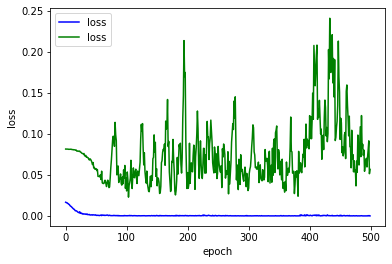

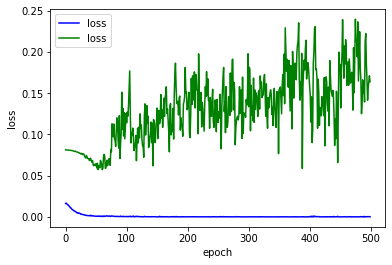

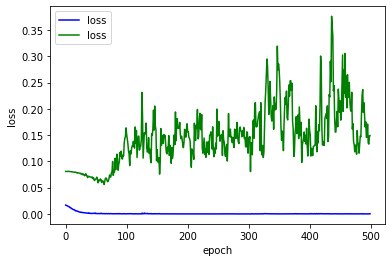

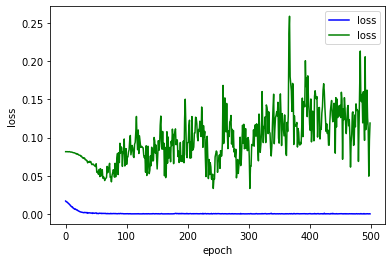

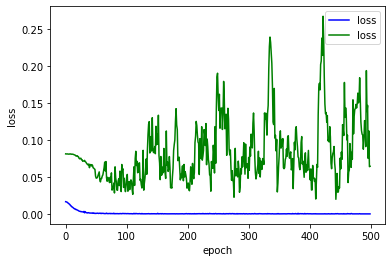

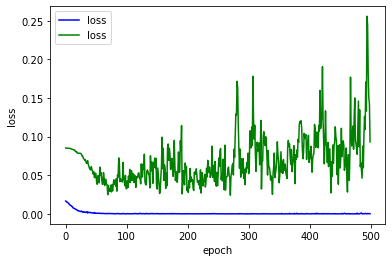

In [8]:
num_epochs = 500
k_folds = 6
kfold = KFold(n_splits=k_folds, shuffle=True)

l_rate = 0.003
loss_function = nn.CrossEntropyLoss()

# final_model = Deep_Emotion()

total_train_acc = []
total_val_acc = []
for fold_i, (train_ids, val_ids) in enumerate(kfold.split(train_dataset)):
    train_sampler = torch.utils.data.SubsetRandomSampler(train_ids)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_ids)
    print(len(train_ids),len(val_ids))
    train_loader = DataLoader(train_dataset, batch_size=batchsize, sampler=train_sampler)
    val_loader = DataLoader(train_dataset, batch_size=batchsize, sampler=val_sampler)
    
    final_model = Deep_Emotion()
#     final_model.apply(reset_weights)
    optimizer = torch.optim.Adam(final_model.parameters(), lr=l_rate)
    
    train_acces = []
    val_acces = []
    train_losses = []
    val_losses = []
    
    for e in range(0,num_epochs):
        train_loss, train_acc = train_final(final_model,loss_function,train_loader,optimizer)
        val_loss, val_acc = test_final(final_model,loss_function,val_loader)
        
        train_acces.append(train_acc)
        val_acces.append(val_acc)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print('Epoch: {} \tTraining Loss: {:.8f} \tValidation Loss {:.8f} \tTraining Acuuarcy {:.2f}% \tValidation Acuuarcy {:.2f}%'
                                                           .format(e+1, train_loss,val_loss,train_acc * 100, val_acc*100))

    total_train_acc.append(train_acces[-1])
    total_val_acc.append(val_acces[-1])
    plot_curve(train_losses,val_losses)

In [9]:
print("average validation accuracy:",np.mean(total_val_acc))
print("average training accuracy:",np.mean(total_train_acc))
total_val_acc

average validation accuracy: 0.6503623
average training accuracy: 0.99721056


[tensor(0.7917),
 tensor(0.6667),
 tensor(0.5000),
 tensor(0.5833),
 tensor(0.7083),
 tensor(0.6522)]

### test 1:26

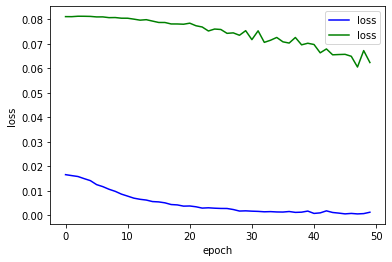

In [9]:
import matplotlib.pyplot as plt
# plt.switch_backend('Agg') # 后端设置'Agg' 参考：https://cloud.tencent.com/developer/article/1559466

plt.figure()                   # 设置图片信息 例如：plt.figure(num = 2,figsize=(640,480))
plt.plot(train_losses,'b',label = 'loss')        # epoch_losses 传入模型训练中的 loss[]列表,在训练过程中，先创建loss列表，将每一个epoch的loss 加进这个列表
plt.plot(val_losses,'g',label = 'loss')  
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()        #个性化图例（颜色、形状等）

In [58]:
k_folds = 6
batchsize = 32
kfold = KFold(n_splits=k_folds, shuffle=False)
num_epochs = 80
l_rate = 1e-3
loss_function = nn.CrossEntropyLoss()


for fold_i, (train_ids, val_ids) in enumerate(kfold.split(train_dataset)):
    if fold_i ==5:
        print(f'----FOLD {fold_i}----')
        print(train_ids)
#         print(val_ids,len(val_ids))

        # 1. define data loader
        train_sampler = torch.utils.data.SubsetRandomSampler(train_ids)
        val_sampler = torch.utils.data.SubsetRandomSampler(val_ids)
        train_loader = DataLoader(train_dataset, batch_size=batchsize, sampler=train_sampler)
        val_loader = DataLoader(train_dataset, batch_size=batchsize, sampler=val_sampler)
        
        # 2. Init model and optimizer
        network = Deep_Emotion()
        network.apply(reset_weights)
        optimizer = torch.optim.Adam(network.parameters(), lr=l_rate)
        
        # 3. train loop
        for e in range(0,num_epochs):
            
            train_loss = 0.0
            val_loss = 0.0
            train_correct = 0
            val_correct = 0
            total = 0
            
#             network.train()
#             for i,data in enumerate(train_loader,0):
#                 print(i)
                
#                 inputs,targets = data
#                 print(targets)
#                 optimizer.zero_grad()
#                 outputs = network(inputs)
#                 loss = loss_function(outputs, targets)
#                 loss.backward()
#                 optimizer.step()
                
#                 # records 
#                 current_loss += loss.item()
#                 _, preds = torch.max(outputs,1)
#                 train_correct += torch.sum(preds == targets.data)
                
#                 break
            
            network.eval()
            for i,data in enumerate(val_loader,0):
                print(i)
                inputs,targets = data
                outputs = network(inputs)
                loss = loss_function(outputs,targets)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                
                total += targets.size(0)
                val_correct += torch.sum(predicted == targets)
                
                print(targets)
                break
                
            

----FOLD 5----
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119]
0
tensor([5, 0, 3, 4, 5, 4, 6, 1, 6, 3, 0, 2, 3, 4, 6, 1, 6, 2, 2, 4, 5, 3, 1])


In [59]:
targets

tensor([5, 0, 3, 4, 5, 4, 6, 1, 6, 3, 0, 2, 3, 4, 6, 1, 6, 2, 2, 4, 5, 3, 1])

In [61]:
predicted

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

In [62]:
val_correct

tensor(3)

In [63]:
predicted == targets

tensor([ True, False, False, False,  True, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
         True, False, False])

In [64]:
total

23

In [42]:
len(val_loader2.sampler)

23

In [62]:
l1_iter = iter(val_loader1)
l2_iter = iter(val_loader2)

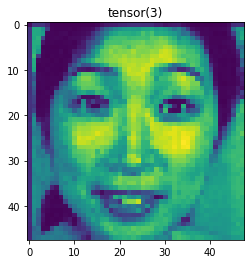

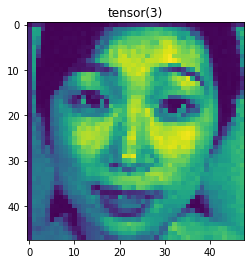

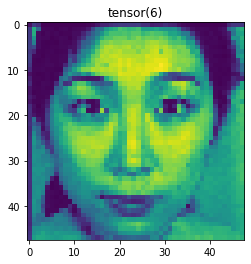

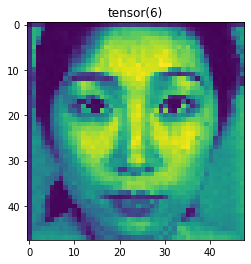

In [65]:
for i in range(2): #Run through 2 epoch
    images, labels = l2_iter.next()
    for image, label in zip(images,labels): # Run through all samples in a batch
        image = np.squeeze(image)
        plt.figure()
        plt.imshow(image.numpy())
        plt.title(label)

In [28]:
len(val_sampler2)

23

In [11]:
kwz_loader = DataLoader(train_dataset, batch_size=2)
dataiter = iter(kwz_loader)

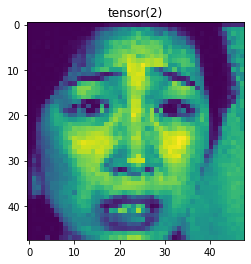

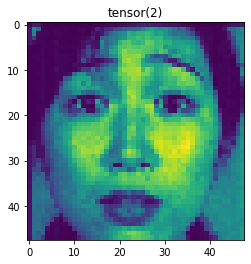

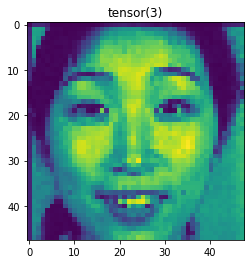

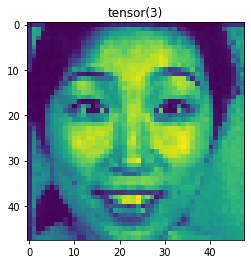

In [13]:
for i in range(2): #Run through 2 epoch
    images, labels = dataiter.next()
    for image, label in zip(images,labels): # Run through all samples in a batch
        image = np.squeeze(image)
        plt.figure()
        plt.imshow(image.numpy())
        plt.title(label)

In [14]:
image = np.squeeze(image)

In [59]:
image.shape

torch.Size([48, 48])